In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'serif'

In [2]:
general_information = pd.read_excel('/home/jiangjingwen/Downloads/LiHui/data/1.一般资料.xlsx')

In [3]:
all_feature = pd.read_excel('/home/jiangjingwen/Downloads/LiHui/data/8.feature_merged_prognosis.xlsx')

In [4]:
grouped = all_feature.groupby(all_feature.columns[1])

In [5]:
group_labels = list(grouped.groups.keys())

In [6]:
hc_data = grouped.get_group(group_labels[0])
coma_data = grouped.get_group(group_labels[1])
awake_data = grouped.get_group(group_labels[2])

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report
from xgboost import XGBClassifier
from sklearn.svm import SVC
import shap

In [8]:
coma_awake_data = pd.concat([coma_data, awake_data], ignore_index=True)

In [9]:
X = coma_awake_data.drop(columns=['patients', 'status_after_6_months'])  # 特征
feature_names = X.columns
y = coma_awake_data['status_after_6_months']  # 目标变量
label2id = {1:0., 2:1.}
y = y.map(label2id)

In [10]:
X = np.array(X)
y = np.array(y)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [12]:
y_test

array([1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

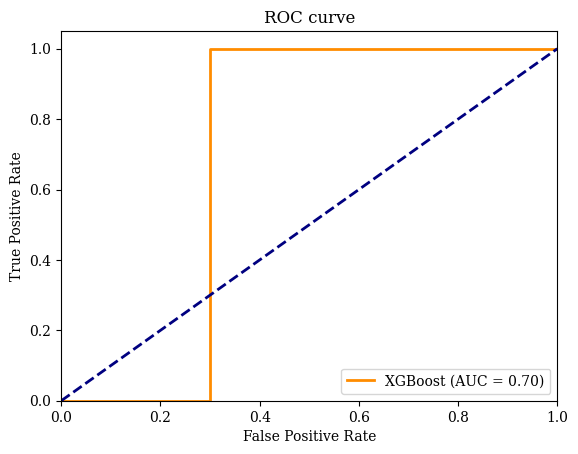

In [13]:
# 使用XGBoost进行分类
model = XGBClassifier()
# model = RandomForestClassifier()
model.fit(X_train, y_train)

# 预测概率
y_pred_proba = model.predict_proba(X_test)[:, 1]

# 计算 ROC 曲线和 AUC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# 绘制 ROC 曲线
plt.figure()
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label='XGBoost (AUC = %0.2f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [14]:
# SHAP分析
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

In [15]:
shap_values.shape

(12, 84)

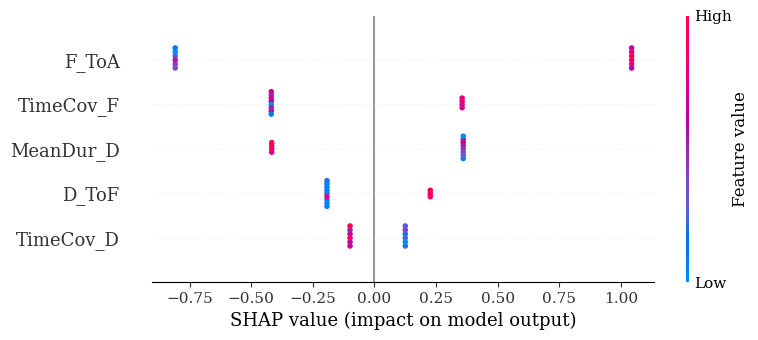

In [16]:
# 汇总解释结果
shap.summary_plot(shap_values, X_test, feature_names=feature_names, max_display=5)

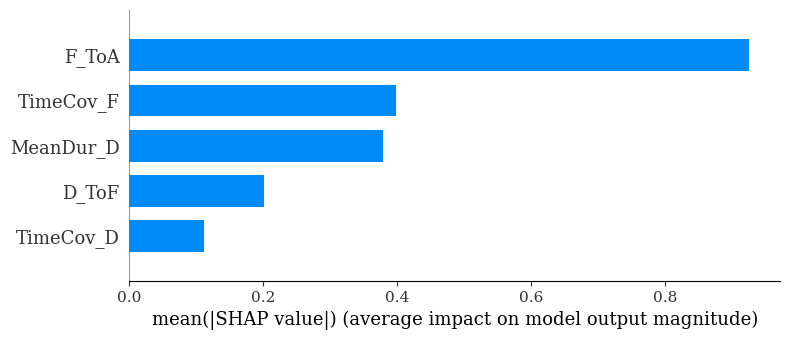

In [17]:
shap.summary_plot(shap_values, X, feature_names=feature_names, plot_type='bar', max_display=5)

In [18]:
# SVM模型
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [19]:
# 实例化StandardScaler对象
# scaler = StandardScaler()
scaler = MinMaxScaler()

In [20]:
coma_feat = coma_data.drop(columns=['patients', 'status_after_6_months', 'age', 'gender'])  # 特征
awak_feat = awake_data.drop(columns=['patients', 'status_after_6_months', 'age', 'gender'])  # 特征

In [21]:
# 对数据框中的列进行标准化
coma_feat_scaled = pd.DataFrame(scaler.fit_transform(coma_feat), columns=coma_feat.columns)
awak_feat_scaled = pd.DataFrame(scaler.fit_transform(awak_feat), columns=awak_feat.columns)

In [22]:
X = pd.concat([coma_feat_scaled, awak_feat_scaled], ignore_index=True) # 特征
feature_names = X.columns

In [23]:
y = coma_awake_data['status_after_6_months']  # 目标变量
label2id = {1:0., 2:1.}
y = y.map(label2id)

In [24]:
X = np.array(X)
y = np.array(y)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [26]:
y_test

array([1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

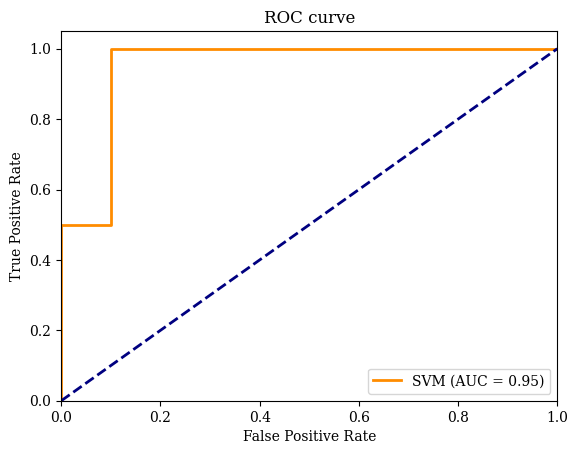

In [27]:
# 构建和训练 SVM 模型
model = SVC(kernel='rbf', probability=True, random_state=42)
model.fit(X_train, y_train)
# 预测概率
y_pred_proba = model.predict_proba(X_test)[:, 1]

# 计算 ROC 曲线和 AUC
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_proba)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# 绘制 ROC 曲线
plt.figure()
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label='SVM (AUC = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

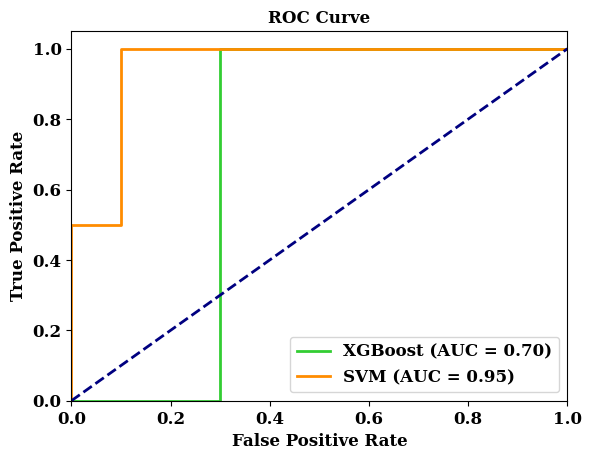

In [28]:
plt.rcParams['font.family'] = 'serif'
font_size = 12
plt.rcParams.update({'font.size': font_size, 'font.weight': 'bold'})
plt.figure()
plt.plot(fpr_xgb, tpr_xgb, color='limegreen', lw=2, label='XGBoost (AUC = %0.2f)' % roc_auc_xgb)
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label='SVM (AUC = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=font_size, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=font_size, fontweight='bold')
plt.title('ROC Curve', fontsize=font_size, fontweight='bold')
plt.legend(loc="lower right")
plt.savefig('xgb_svm_roc.jpg', dpi=400)
plt.show()

In [29]:
# 使用KernelExplainer解释模型
# explainer = shap.Explainer(model.predict, X_train)
explainer = shap.KernelExplainer(model.predict, X_train)
shap_values = explainer.shap_values(X)

  0%|          | 0/29 [00:00<?, ?it/s]

In [30]:
shap_values.shape

(29, 82)

In [31]:
print(y_test)

[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


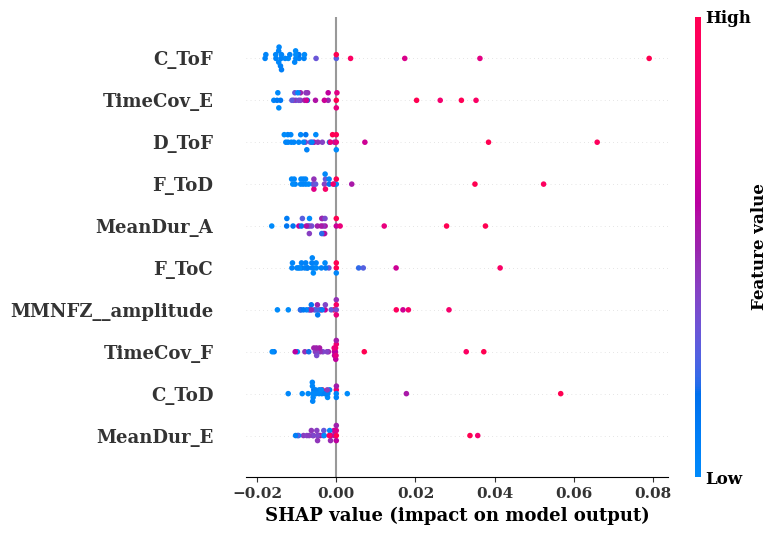

In [32]:
# plt.rcParams.update({'font.size': plt.rcParamsDefault['font.size'], 'font.weight': plt.rcParamsDefault['font.weight']})
shap.summary_plot(shap_values, X, feature_names=feature_names, max_display=10, show=False)

font_size = 12
plt.rcParams.update({'font.size': font_size, 'font.weight': 'bold'})

fig = plt.gcf()

colorbar = fig.get_axes()[1]
ylabel = colorbar.set_ylabel('Feature value', fontweight='bold', fontsize=font_size)
for label in colorbar.get_yticklabels():
    label.set_fontweight('bold')
    label.set_fontsize(font_size)
    
plt.xlabel('SHAP value (impact on model output)', fontweight='bold')

plt.savefig("shap_summary_plot.jpg", dpi=400, bbox_inches='tight', pad_inches=0.5)

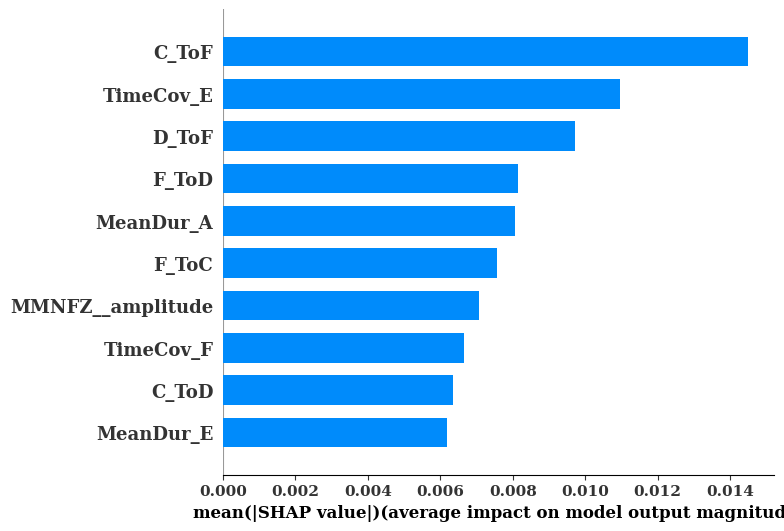

In [33]:
shap.summary_plot(shap_values, X, feature_names=feature_names, plot_type='bar', max_display=10, show=False)
plt.xlabel('mean(|SHAP value|)(average impact on model output magnitude)', fontweight='bold', fontsize=font_size)
plt.savefig("shap_summary_plot_bar.jpg", dpi=400, bbox_inches='tight', pad_inches=1.0)

In [34]:
shap_values.shape

(29, 82)

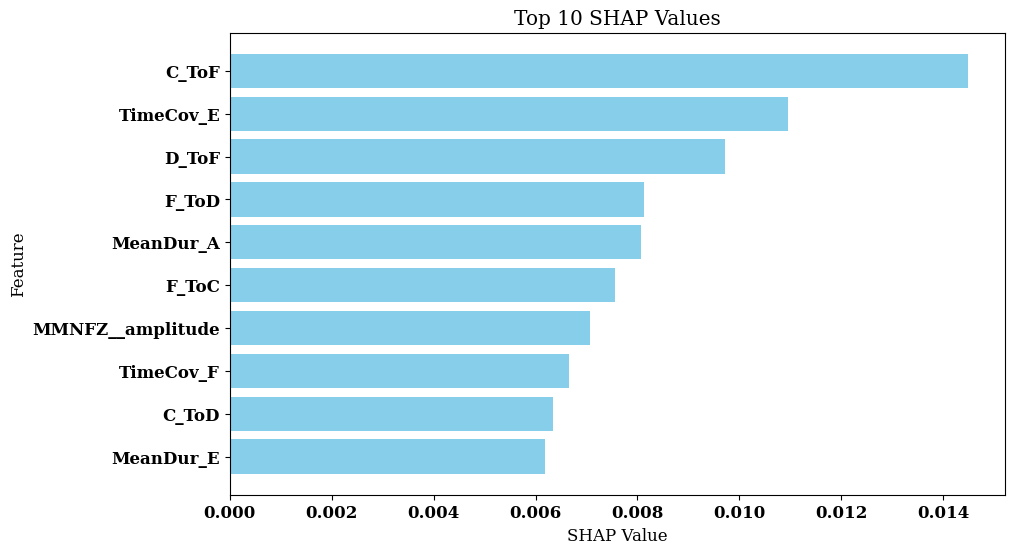

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# 获取要显示的特征名称和对应的SHAP值
shap_values_summary = np.abs(shap_values).mean(axis=0)
feature_names = np.array(feature_names)

# 排序特征和SHAP值
sorted_indices = np.argsort(shap_values_summary)
top_features = feature_names[sorted_indices][-10:]  # 取出排名前10的特征
top_shap_values = shap_values_summary[sorted_indices][-10:]

# 创建水平条形图
plt.figure(figsize=(10, 6))
plt.barh(top_features, top_shap_values, color='skyblue')
plt.xlabel('SHAP Value')
plt.ylabel('Feature')
plt.title('Top 10 SHAP Values')

plt.show()